In [1]:
import functools
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:

class UltimateGuitarSongDataset(Dataset):
    def __init__(self, filename="../../out/chord_progressions_augmented.json"):
        with open(filename) as f:
            songs_info = json.load(f)
        songs_info = [(song_info[0], song_info[1][:8]) for song_info in songs_info if len(song_info[1]) > 8]
        self.songs_info = songs_info

        song_complexities, songs = zip(*songs_info)
        self.song_complexities = song_complexities
        self.songs = songs

        self.unique_chords = sorted(list(functools.reduce(lambda acc, x: acc | set(x), songs, set())))

        self.unique_chords_to_tensors = {}
        for i, chord in enumerate(self.unique_chords):
            tensor = torch.zeros(len(self.unique_chords), dtype=torch.long)
            tensor[i] = 1
            self.unique_chords_to_tensors[chord] = tensor

        self.data = []
        for (song_complexity, song) in songs_info:
            x = (torch.cat((torch.FloatTensor(song_complexity), self.unique_chords_to_tensors[chord])) for chord in song[:-1])
            y = (self.unique_chords_to_tensors[chord] for chord in song[1:])
            self.data.append((torch.stack(list(x)), torch.stack(list(y))))        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = UltimateGuitarSongDataset()
_, train_dataset, test_dataset = random_split(dataset, [0.0, 0.80, 0.20])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

OUTPUT_SIZE = len(dataset.unique_chords)
INPUT_SIZE = OUTPUT_SIZE + len(dataset.song_complexities[0])

print(f"Input size: {INPUT_SIZE}")

Input size: 135


In [3]:
class RNNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, state_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.state_size = state_size

        self.i2s = torch.nn.Linear(self.input_size + self.state_size, self.state_size)
        self.i2h = torch.nn.Linear(self.input_size + self.state_size, self.hidden_size)
        self.h2o = torch.nn.Linear(self.hidden_size, self.output_size)
        self.dropout = torch.nn.Dropout(0.10)
        self.softmax = torch.nn.LogSoftmax(dim=0)

    def forward(self, i: torch.Tensor, state: torch.Tensor):
        i_ = torch.cat((i, state))
        s = self.i2s(i_)
        h = self.i2h(i_)
        o = self.h2o(torch.relu(h))
        o = self.dropout(o)
        return self.softmax(o), s

    def init_hidden(self):
        return torch.zeros(self.state_size)

In [4]:
def train_loop(dataloader, model, loss, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (batched_x, batched_y) in enumerate(dataloader):
        cost = 0
        for x, y in zip(batched_x, batched_y):
            state = model.init_hidden()
            for i, (x_, y_) in enumerate(zip(x, y)):
                pred, state = model(x_, state)
                cost += loss(pred, torch.argmax(y_))
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_loss = cost.item() / (batched_x.size(0) * batched_x.size(1) * batched_x.size(2))
        total_loss += batch_loss

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx} loss: {batch_loss}")

    return total_loss


def test_loop(dataloader, model, loss, epoch):
    model.eval()
    test_loss, correct = 0, 0
    total_items = 0
    with torch.no_grad():
        for batch_idx, (batched_x, batched_y) in enumerate(dataloader):
            batch_loss = 0
            for x, y in zip(batched_x, batched_y):
                state = model.init_hidden()
                for x_, y_ in zip(x, y):
                    pred, state = model(x_, state)
                    batch_loss += loss(pred, torch.argmax(y_))

                    # Accuracy count
                    total_items += 1
                    _, indices = torch.topk(pred, k=5)
                    if torch.argmax(y_).item() in indices:
                        correct += 1

            batch_loss /= batched_x.size(0) * batched_x.size(1) * batched_x.size(2)
            test_loss += batch_loss
        accuracy = 100 * correct / total_items
        print(f"Accuracy: {accuracy:.2f}")
    return test_loss.item(), accuracy


Using cpu device
Batch 0 loss: 0.03628148881215898
Batch 100 loss: 0.029450326747995206
Batch 200 loss: 0.028052995066163402
Batch 300 loss: 0.030505970546177454
Batch 400 loss: 0.027055784760328827
Batch 500 loss: 0.02622333506427745
Batch 600 loss: 0.026975506575650007
Batch 700 loss: 0.02419534309831246
Batch 800 loss: 0.022985167730422248
Batch 900 loss: 0.024288744648928363
Batch 1000 loss: 0.022123861565161003
Batch 1100 loss: 0.023208533393012154
Batch 1200 loss: 0.022209791153196306
Batch 1300 loss: 0.021682432467344578
Accuracy: 72.70
---------------
Epoch: 1
Loss in training:  33.505525220638845
Loss in test: 6.450981140136719
---------------

Batch 0 loss: 0.02308143736824157
Batch 100 loss: 0.024063185030821138
Batch 200 loss: 0.020796540679124297
Batch 300 loss: 0.02024047891929667
Batch 400 loss: 0.021323790373625577
Batch 500 loss: 0.022929000854492187
Batch 600 loss: 0.021008040413023933
Batch 700 loss: 0.017609556894453746
Batch 800 loss: 0.02228532417741402
Batch 900 

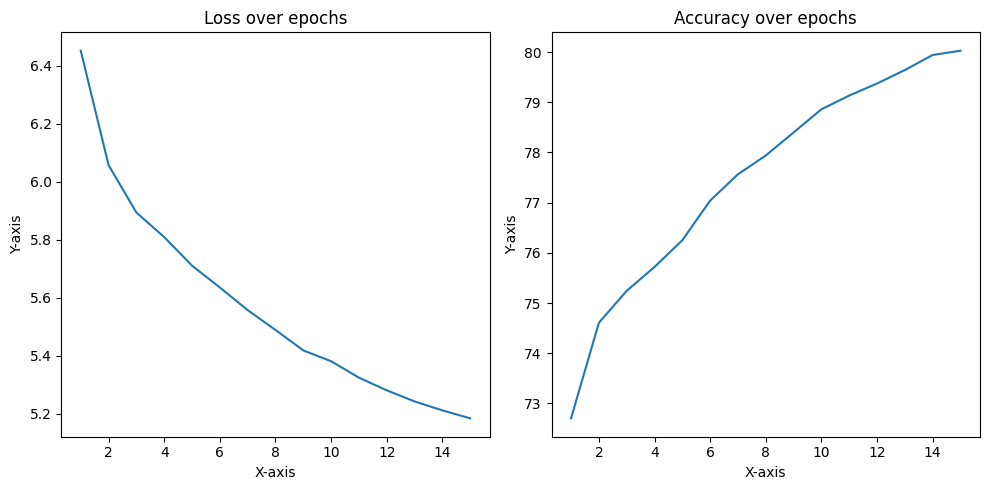

In [10]:
HIDDEN_SIZE = 30
STATE_SIZE = 15

def plot(epochs, losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(epochs, losses)
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')

    ax2.plot(epochs, accuracies)
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    plt.tight_layout()
    plt.show()
    
def main():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
    print(f"Using {device} device")

    model = RNNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    loss = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    epochs = 15
    losses, accuracies = [], []
    for epoch in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss, optimizer, epoch)
        test_loss, accuracy = test_loop(test_dataloader, model, loss, epoch)

        print("---------------")
        print(f"Epoch: {epoch+1}")
        print("Loss in training: ", train_loss)
        print("Loss in test:", test_loss)
        print("---------------\n")
        losses.append(test_loss)
        accuracies.append(accuracy)
    torch.save(model.state_dict(), "../../out/rnn_chord_progressions_classification.pth")
    plot(range(1, epochs + 1), losses, accuracies)

main()

In [11]:
def sandbox():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
    print(f"Using {device} device")
    model = RNNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    model.load_state_dict(torch.load("../../out/rnn_chord_progressions_classification.pth"))
    model.eval()

    with torch.no_grad():
        while True:
            try:
                chord_complexity = input("Enter three numbers to associate complexity (variance, mean, entropy)").strip()
                chord_progression = input("Enter chord progression: ").strip()
            except KeyboardInterrupt:
                break

            if chord_complexity =="" or chord_progression == "":
                break

            complexity_floats = list(map(float, chord_complexity.split(",")))
            complexity_tensor = torch.FloatTensor(complexity_floats)
            chord_tensors = [torch.cat((complexity_tensor, dataset.unique_chords_to_tensors[chord])) for chord in chord_progression.split()]

            state = model.init_hidden()
            pred = None
            for tensor in chord_tensors:
                pred, state = model(tensor, state)

            prob = torch.exp(pred)
            prob = prob / torch.sum(prob)
            for prob, idx in zip(*torch.topk(prob, k=8)):
                idx = idx.item()
                chord = dataset.unique_chords[idx]
                print(f"{chord}: {prob.item():.2f}")
            print("\nExpected: ", chord_progression + " " + dataset.unique_chords[torch.argmax(pred).item()])
sandbox()

Using cpu device


Enter three numbers to associate complexity (variance, mean, entropy) 0, 0.7, 3
Enter chord progression:  C


G: 0.38
F: 0.14
Am: 0.10
C: 0.10
D: 0.05
Dm: 0.05
A#: 0.04
Em: 0.04

Expected:  C G


Enter three numbers to associate complexity (variance, mean, entropy) 0, 1, 3
Enter chord progression:  C


G: 0.47
F: 0.18
C: 0.09
D: 0.07
A#: 0.05
Am: 0.04
Dm: 0.02
Em: 0.01

Expected:  C G


Enter three numbers to associate complexity (variance, mean, entropy) 9, 1, 3
Enter chord progression:  C


Cm7: 0.44
Dm7: 0.35
Fm7: 0.04
D#: 0.03
G#: 0.02
Am7: 0.02
F7: 0.02
A7: 0.02

Expected:  C Cm7


Enter three numbers to associate complexity (variance, mean, entropy) 1, 1, 3
Enter chord progression:  C


F: 0.11
Am: 0.11
Am7: 0.09
Dm7: 0.06
Gsus4: 0.04
D7: 0.03
E7: 0.03
G: 0.03

Expected:  C F


Enter three numbers to associate complexity (variance, mean, entropy) 0.5, 1, 3
Enter chord progression:  C


F: 0.22
G: 0.19
Am: 0.12
C: 0.07
D: 0.06
Dm: 0.05
Em: 0.04
A#: 0.04

Expected:  C F


Enter three numbers to associate complexity (variance, mean, entropy) 1, 1, 3
Enter chord progression:  
